# Propuesta  
  
Probamos una versión más simplificada del proceso de clustering sin crear caracteristicas adicionales.

# INIT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librerias

In [ ]:
# !pip install featuretools # install the missing module # No lo vamos a usar esta vez

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

from modules import preprocessing_module as pm
from modules import kmeans_module as km_m
from modules.get_data import get_data
from modules import feature_creation_module as fcm

## Importacion datos

### CSVs

In [5]:
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
df_ws = get_data('daily_sales_with_events.csv')

/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering/modules/get_data.py:23: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [6]:
display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_ws.head())

,fecha,event
0,2011-02-06,SuperBowl
1,2011-08-01,Ramadan starts
2,2011-11-24,Thanksgiving
3,2012-01-01,NewYear
4,2012-02-05,SuperBowl


,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
0,ACCESORIES_1_008,NYC_1,2011-01-29,12,2011,4,0.6118,7.3416,1,Saturday,5,NaN
1,ACCESORIES_1_009,NYC_1,2011-01-29,2,2011,4,2.0748,4.1496,1,Saturday,5,NaN
2,ACCESORIES_1_015,NYC_1,2011-01-29,4,2011,4,0.9310,3.7240,1,Saturday,5,NaN
3,ACCESORIES_1_016,NYC_1,2011-01-29,5,2011,4,0.9310,4.6550,1,Saturday,5,NaN
4,ACCESORIES_1_022,NYC_1,2011-01-29,2,2011,4,9.1238,18.2476,1,Saturday,5,NaN


In [7]:
# Seleccionar solo años 2014 a 2016 de df_ws
df_ws = df_ws[(df_ws['year'] >= 2014) & (df_ws['year'] <= 2016)]

# df_ws_origin = df_ws.copy() # Para recuperar eventos

# Cambiamos NaN de event por None
df_ws['event'] = df_ws['event'].fillna('None')

In [8]:
df_ws.shape

(9693001, 12)

In [9]:
df_ws.head()

,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
8857275,ACCESORIES_1_001,NYC_1,2014-01-01,1,2014,1,10.9858,10.9858,1,Wednesday,2,NewYear
8857276,ACCESORIES_1_004,NYC_1,2014-01-01,2,2014,1,6.1712,12.3424,1,Wednesday,2,NewYear
8857277,ACCESORIES_1_005,NYC_1,2014-01-01,1,2014,1,4.0964,4.0964,1,Wednesday,2,NewYear
8857278,ACCESORIES_1_008,NYC_1,2014-01-01,3,2014,1,0.6118,1.8354,1,Wednesday,2,NewYear
8857279,ACCESORIES_1_010,NYC_1,2014-01-01,3,2014,1,3.9501,11.8503,1,Wednesday,2,NewYear


# KISS Clustering  
  
> https://www.kaggle.com/code/nguynhonghi/clustering-supermarket-sales-k-means-analysis

## Unidades x Ingresos

In [12]:
# No vamos a tener en cuenta las fechas ni las tiendas asi que vamos a agrupar por producto
# conservando las columnas de units, raw_earn y sell_price
df = df_ws[['item','units','raw_earn','sell_price']]

display(df.shape)

df = df.groupby('item').agg({
    'units': 'sum',            # Suma total de unidades
    'sell_price': 'mean',       # Media de precios de venta
    'raw_earn': 'sum'           # Suma total de ingresos brutos
}).reset_index()

display(df.shape)

df.head()

(9693001, 4)

(3049, 4)

,item,units,sell_price,raw_earn
0,ACCESORIES_1_001,3504,10.991607,38517.4650
1,ACCESORIES_1_002,2220,5.276346,11715.2518
2,ACCESORIES_1_003,1435,3.943246,5652.2340
3,ACCESORIES_1_004,17890,6.171200,110402.7680
4,ACCESORIES_1_005,6569,3.815668,25087.1516


In [13]:
df.describe()

,units,sell_price,raw_earn
count,3049.000000,3049.000000,3.049000e+03
mean,10377.577566,5.585784,3.847556e+04
std,19028.000837,4.537883,5.860614e+04
min,21.000000,0.242349,3.520776e+02
25%,2501.000000,2.633253,1.244581e+04
50%,4983.000000,4.204572,2.270971e+04
75%,10589.000000,7.260021,4.234732e+04
max,374044.000000,38.957736,1.112604e+06


In [14]:
df.isnull().sum()

,0
item,0
units,0
sell_price,0
raw_earn,0


### RAW_DF

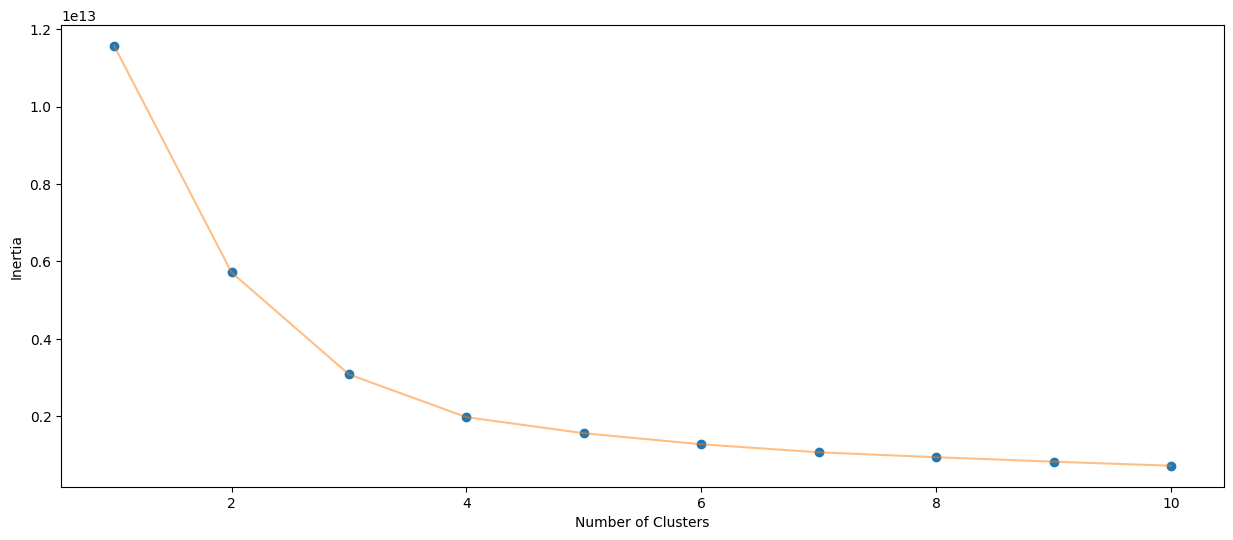

In [46]:
# Importamos Kmeans
from sklearn.cluster import KMeans

'''Products sold and raw_earn'''

X1 = df[['units' , 'raw_earn']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300,
                        tol=0.0001,  random_state= 42  , algorithm='lloyd') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

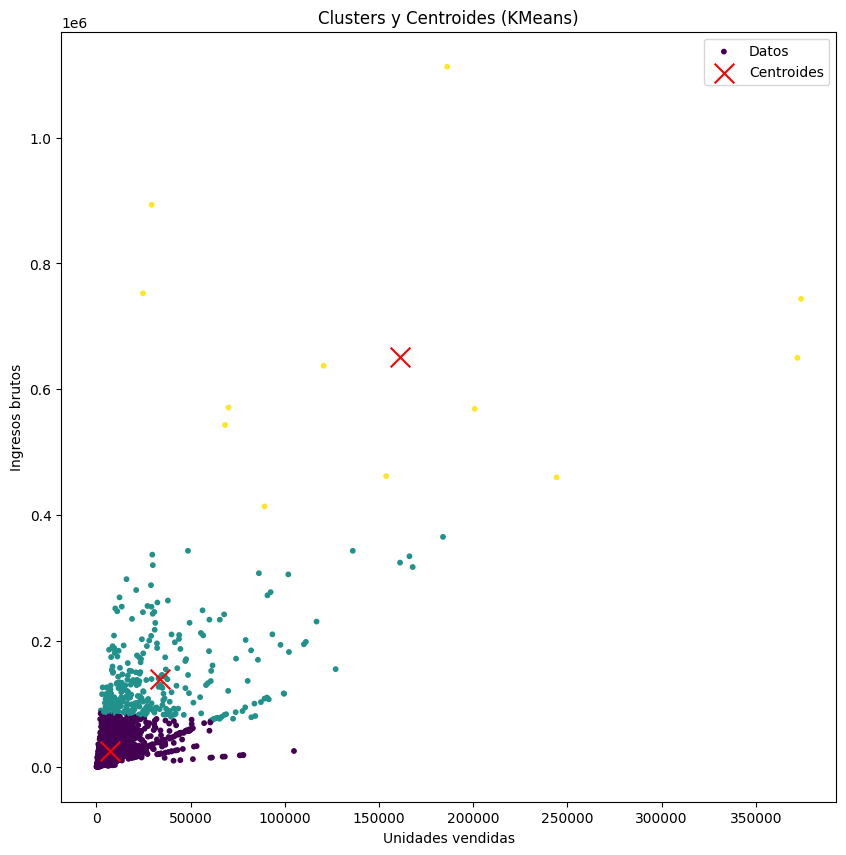

In [47]:
import matplotlib.pyplot as plt
algorithm = (KMeans(n_clusters = 3 ,init='k-means++', n_init = 10 ,max_iter=300,
                        tol=0.0001,  random_state= 42  , algorithm='lloyd') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

plt.figure(figsize=(10,10))

# Graficar los puntos de datos y colorearlos según las etiquetas de los clusters
plt.scatter(X1[:, 0], X1[:, 1], c=labels1, cmap='viridis', marker='o', s=10, label='Datos')

# Graficar los centroides de los clusters
plt.scatter(centroids1[:, 0], centroids1[:, 1], c='red', marker='x', s=200, label='Centroides')

plt.title("Clusters y Centroides (KMeans)")
plt.xlabel("Unidades vendidas")
plt.ylabel("Ingresos brutos")
plt.legend()
plt.show()


### SCALED_DF

In [48]:
# PREPROCESAMOS DATOS
df_items = df[['item']]
df_to_scale = df[['units','sell_price','raw_earn']]

scaled_df = pm.preprocess_features(df_to_scale)

# Concatenamos df_items y scaled_df
scaled_df = pd.concat([df_items, scaled_df], axis=1)

scaled_df.head()

Cat cols: 0
Num cols: 3


,item,units,sell_price,raw_earn
0,ACCESORIES_1_001,-0.182864,1.466906,0.528661
1,ACCESORIES_1_002,-0.341617,0.231646,-0.367689
2,ACCESORIES_1_003,-0.438675,-0.056481,-0.570456
3,ACCESORIES_1_004,1.595821,0.425054,2.932731
4,ACCESORIES_1_005,0.196093,-0.084055,0.079509


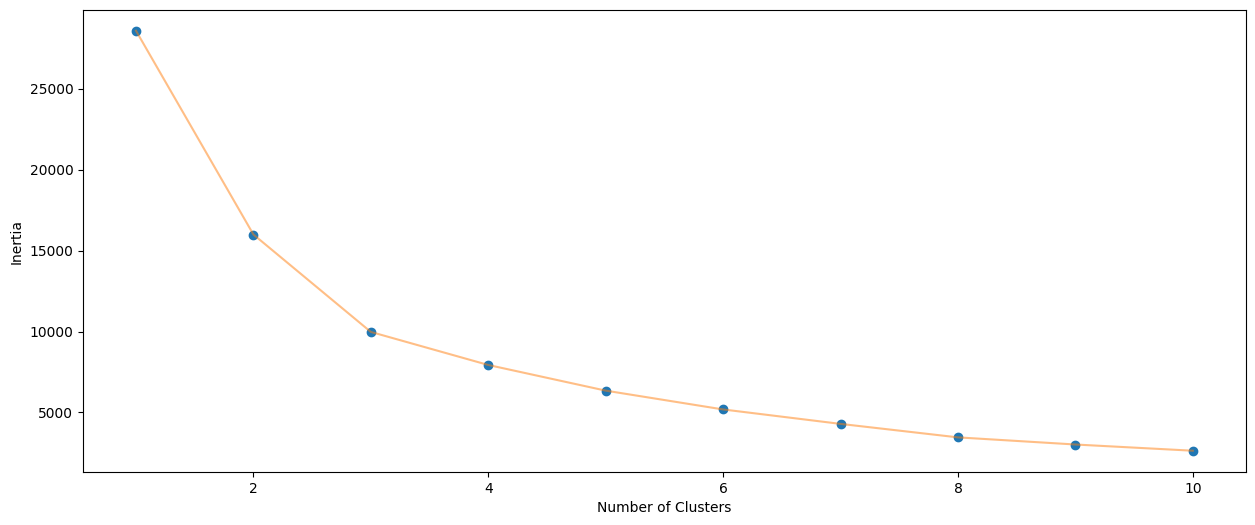

In [49]:
# Lo mismo pero con scaled_df
'''Products sold and raw_earn'''

X1 = scaled_df[['units' , 'raw_earn']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300,
                        tol=0.0001,  random_state= 111  , algorithm='lloyd') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

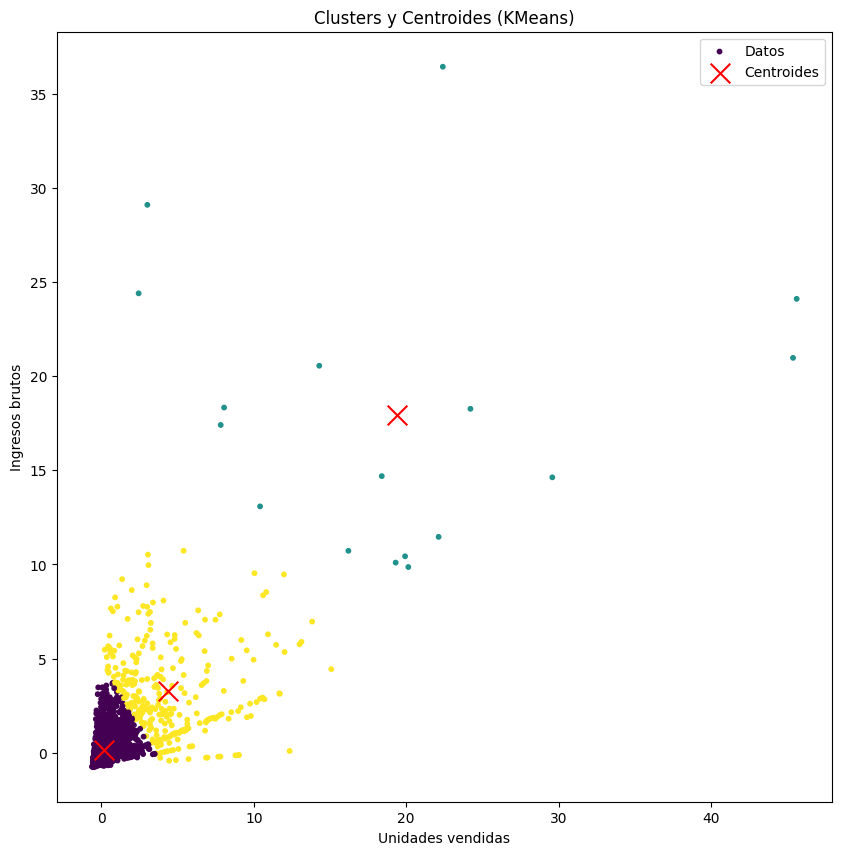

In [50]:
algorithm = (KMeans(n_clusters = 3 ,init='k-means++', n_init = 10 ,max_iter=300,
                        tol=0.0001,  random_state= 42  , algorithm='lloyd') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

plt.figure(figsize=(10,10))

# Graficar los puntos de datos y colorearlos según las etiquetas de los clusters
plt.scatter(X1[:, 0], X1[:, 1], c=labels1, cmap='viridis', marker='o', s=10, label='Datos')

# Graficar los centroides de los clusters
plt.scatter(centroids1[:, 0], centroids1[:, 1], c='red', marker='x', s=200, label='Centroides')

plt.title("Clusters y Centroides (KMeans)")
plt.xlabel("Unidades vendidas")
plt.ylabel("Ingresos brutos")
plt.legend()
plt.show()


## Unidades x Sell_Price (rango de precios)

### SCALED_DF

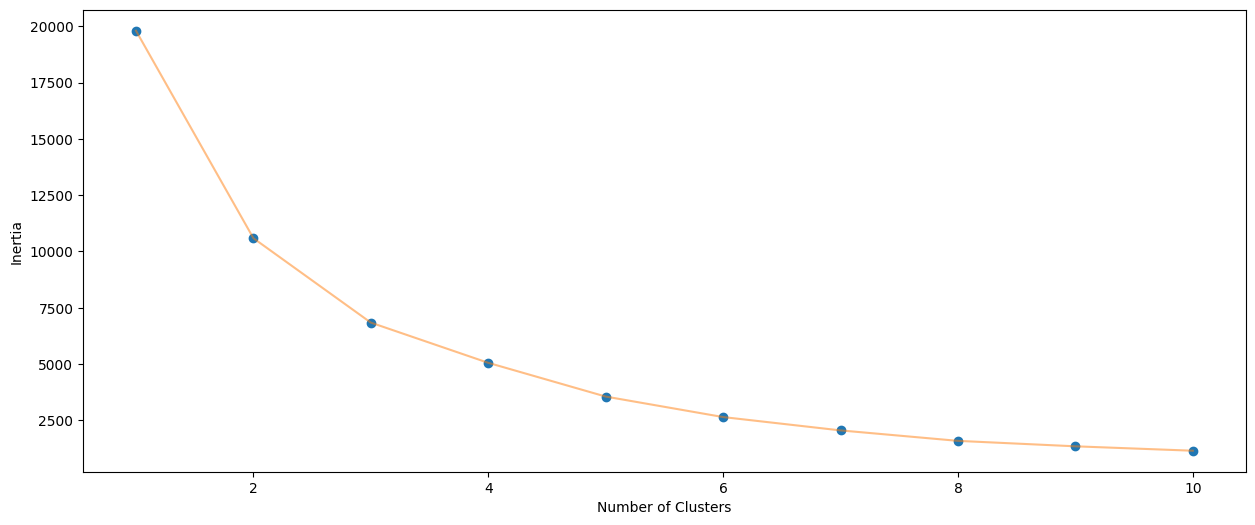

In [52]:
# Lo mismo pero con scaled_df
'''Products sold and sell_price'''

X1 = scaled_df[['units' , 'sell_price']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300,
                        tol=0.0001,  random_state= 111  , algorithm='lloyd') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

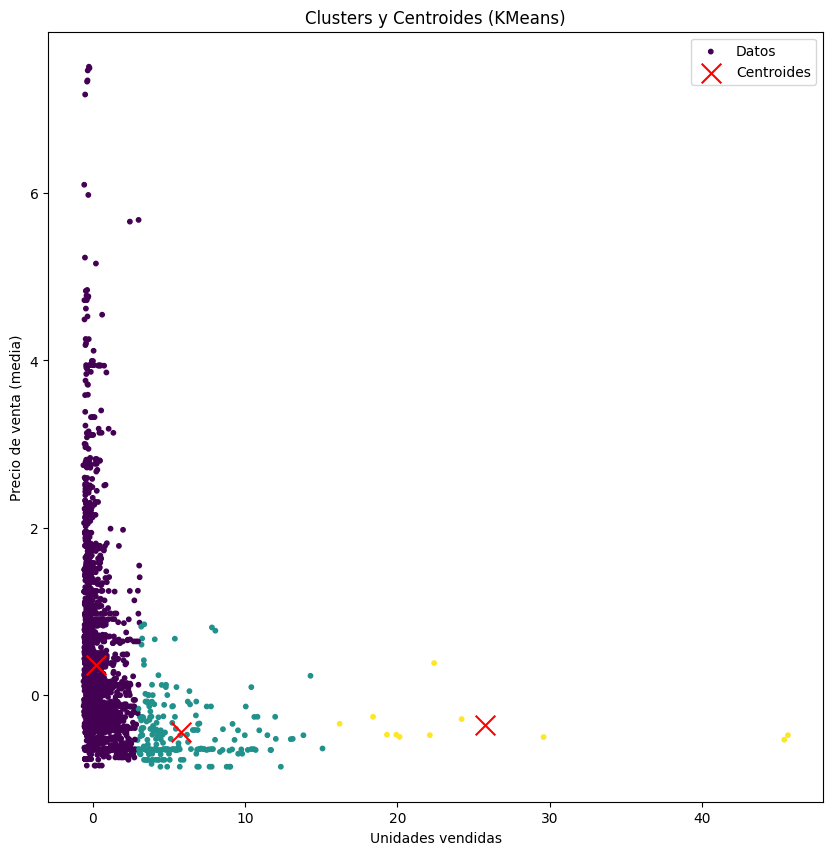

In [53]:
algorithm = (KMeans(n_clusters = 3 ,init='k-means++', n_init = 10 ,max_iter=300,
                        tol=0.0001,  random_state= 42  , algorithm='lloyd') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

plt.figure(figsize=(10,10))

# Graficar los puntos de datos y colorearlos según las etiquetas de los clusters
plt.scatter(X1[:, 0], X1[:, 1], c=labels1, cmap='viridis', marker='o', s=10, label='Datos')

# Graficar los centroides de los clusters
plt.scatter(centroids1[:, 0], centroids1[:, 1], c='red', marker='x', s=200, label='Centroides')

plt.title("Clusters y Centroides (KMeans)")
plt.xlabel("Unidades vendidas")
plt.ylabel("Precio de venta (media)")
plt.legend()
plt.show()
